# Colombian Newspaper analyis: A network science analysis

This report aims to analyze a Colombian newspaper news through network science. We conduct a textual analysis of approximately 90 articles, equally distributed among the topics of politics, education, and technology. By using co-occurrence networks, we map out conceptual associations within the articles to visually represent the typical connections made by the newspaper’s journalists. This approach allows us to illustrate El Tiempo’s editorial slant through graphical representations of the networked concepts.

The data was gathered manually from news sources in 2024. We'll try to draw conclusions about the news and potential biases, but there are limitations. These include the limited timeframe, small sample size, and subjective exclusion of certain words. So, the findings may not perfectly reflect reality. Still, we expect this analysis to help identify the main topics and biases in this Colombian newspaper.

#### Dataset
You can find the dataset at[/term_project/data/articles](/term_project/data/articles ) It contains a collection of articles. Here's an example sample:

```json
{
    "title": "Cookies: en que momento es recomendable no aceptarlas? Le contamos",
    "url": "https://www.eltiempo.com/tecnosfera/dispositivos/cookies-en-que-momento-es-recomendable-no-aceptarlas-le-contamos-3336305",
    "category": "tech",
    "content": [
      "Las cookies son fragmentos de texto que los sitios web envian a los navegadores con el fin de recordar la informacion de sus busquedas, lo que le facilita encontrar informacion de su idioma, almacena los articulos que ha anadido a su carrito de compras, entre otros datos.",
}
```

#### Packages

* Data handling
  * Pandas
* Text Processing
  * NLTK
  * Spacy
  * Regex (re)
* Network Analysis
  * Networkx

#### Installation instructions

1) pipenv install
2) pipenv run python -m spacy download es_core_news_lg

# Setup the project


In [50]:
import spacy
import pandas as pd
import json
import nltk
from nltk.corpus import stopwords
import re
from unidecode import unidecode
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from data.stop_words import STOP_WORDS

# Load the medium-sized Spanish model
nlp = spacy.load('es_core_news_lg')
# Download NLTK stop words 
nltk.download('stopwords')
# Get stop words for Spanish
spanish_stop_words = stopwords.words('spanish')
spanish_stop_words.extend(STOP_WORDS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load the data

In [51]:
def load_json_from_path(file_path:str):
    """
    Load JSON data from a file path.

    Parameters:
        file_path (str): The path to the JSON file.

    Returns:
        dict: The JSON data loaded from the file.
    """
    with open(file_path, 'r', encoding="utf8") as file:
        json_data = json.load(file)
    return json_data

In [52]:
articles = load_json_from_path('./data/articles.json')

In [53]:
f'There are {len(articles)} articles'

'There are 54 articles'

In [54]:
articles[0]

{'title': 'Petro y la lucha de clases / Columna de Felipe López Caballero',
 'url': 'https://www.eltiempo.com/politica/gobierno/petro-y-la-lucha-de-clases-columna-de-felipe-lopez-caballero-3333631',
 'category': 'politic',
 'content': ['La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  '2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  '3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores intern

# Data cleaning

* **Removing Special Characters**: Characters such as (%,$,#, etc.) do not provide any useful information, so they will be ignored
* **Remove stop words**:  Stop words are common words in a language that are often used to connect sentences or fill gaps in speech, such as  (el,ella, eso,aqui, alla, etc) even These words do not carry significant meaning on their own and are unlikely to contribute to the analysis of the text
* **Apply lemmatization**: Lemmatization is a process where words are reduced to their base or root form. This is particularly useful because some words may have different forms but convey the same concept. For instance, words like (cambio, cambia, cambiará, cambió, cambiaron, etc.) all stem from the same root word, "cambiar" (to change). By lemmatizing these words, we can simplify the data and ensure consistency in representing concepts, leading to more accurate analysis results.



In [55]:
import re
from unidecode import unidecode

def preprocess_text(text):
    
    text = unidecode(text) # Remove accents 
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower()) # Remove punctuation and convert to lowercase

    return text

def remove_stop_words(text, custom_stop_words):
    """
    Remove custom stop words from the input text.

    Args:
        text (str): Input text.
        custom_stop_words (list): List of custom stop words to be removed.

    Returns:
        str: Text with custom stop words removed.
    """
    stop_words = set(custom_stop_words)
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

def lemmatize(text):
    # Process the text
    doc = nlp(text)
    # Extract the lemma for each token in the text
    lemmas = [token.lemma_ for token in doc]
    return lemmas

* Extract paragraphs from articles and unify them into a single list.

In [56]:
categories = [doc['category'] for doc in articles for para in doc['content']]

In [72]:
doc_id = [id for id, doc in enumerate(articles) for para in doc['content']]

In [57]:
documents = [para for doc in articles for para in doc['content']]

In [58]:
len(categories), len(documents)

(685, 685)

In [74]:
list(zip(documents[0:5],categories[0:5], doc_id[0:5]))

[('La explicación está en la narrativa que Petro y sus redes sociales han creado. Según esta: 1) Colombia ha estado gobernada durante 200 años por unas élites corruptas interesadas solamente en enriquecerse y perpetuarse en el poder.',
  'politic',
  0),
 ('2) Con Petro llegaría el primer presidente de izquierda cuya preocupación son los pobres y la justicia social.',
  'politic',
  0),
 ('3) Los dueños de Colombia no estarían dispuestos a ceder sus privilegios ante un exguerrillero que busca el cambio.',
  'politic',
  0),
 ('Esa narrativa es simplista, efectista y dañina. Para comenzar, el problema no es que Petro sea un exguerrillero. Si el presidente fuera Antonio Navarro la economía estaría funcionando mejor y la polarización no estaría disparada. La mitad del estancamiento del PIB obedece a factores internacionales, pero la otra mitad tiene nombre propio. El problema es que Petro, un agitador político brillante, ha resultado un administrador incompetente con una personalidad para

* Apply cleaning

In [60]:
documents_clean = [remove_stop_words(preprocess_text(' '.join(lemmatize(d))),spanish_stop_words) for d in documents]

* Data after cleaning

In [61]:
documents_clean[0:3]

['explicacion narrativa petro red social crear colombia gobernado elite corrupto interesado enriquecer perpetuar',
 'petro presidente izquierda preocupacion pobre justicia social',
 'dueno colombia dispuesto ceder privilegio exguerrillero buscar cambio']

In [62]:
def text_to_network(words: list[str]):
    network_dictionary = []
    limit = len(words) - 3
    for idx, word in enumerate(words):
        if idx == limit:
            break
        network_dictionary.extend(
            [
                {"_from": word, "to": words[idx + 1], "weight": 3},
                {"_from": word, "to": words[idx + 2], "weight": 2},
                {"_from": word, "to": words[idx + 3], "weight": 1},
            ]
        )
    network_dictionary.extend([
        {"_from": words[-3], "to": words[-2], "weight": 3},
        {"_from": words[-3], "to": words[-1], "weight": 2},
        {"_from": words[-2], "to": words[-1], "weight": 3}
    ])
    return network_dictionary


In [75]:
network_dict_dataset = [] 
network_dict_dataset.extend([
    relation | {"category":category} | {"doc_id": doc_id}
    for doc, category,doc_id  in zip(documents_clean, categories,doc_id)
    if len(doc.split()) >= 5
    for relation in text_to_network(doc.split())
])
#network_dict_dataset = [relation for sentence in network_dict_dataset for relation in sentence]

In [76]:
network_df = pd.DataFrame(network_dict_dataset)

In [77]:
network_df.shape

(32673, 5)

In [80]:
network_df

,_from,to,weight,category,doc_id
0,explicacion,narrativa,3,politic,0
1,explicacion,petro,2,politic,0
2,explicacion,red,1,politic,0
3,narrativa,petro,3,politic,0
4,narrativa,red,2,politic,0
...,...,...,...,...,...
32668,ministerio,aclarar,2,education,53
32669,ministerio,rincon,1,education,53
32670,educacion,aclarar,3,education,53
32671,educacion,rincon,2,education,53


In [137]:
score_network_df = network_df.groupby(['_from','to','category','doc_id']).agg(score=('weight', 'sum')).reset_index()

In [138]:
score_network_df.shape

(31133, 5)

In [139]:
len(score_network_df['_from'].value_counts())

3604

In [128]:
score_network_df.groupby(['_from','to'])['category'].transform('count')

0        2
1        2
2        1
3        1
4        2
        ..
31128    1
31129    1
31130    1
31131    1
31132    1
Name: category, Length: 31133, dtype: int64

In [143]:
score_network_df.sort_values('score')

,_from,to,category,doc_id,score
31132,zoom,wide,tech,15,1
21542,partido,carta,politic,7,1
8908,dialogo,llevar,politic,1,1
21538,partidario,anuncio,tech,28,1
21536,particularmente,socioeconomico,politic,13,1
...,...,...,...,...,...
17827,map,view,tech,39,24
9991,educacion,superior,education,45,27
8687,desplazamiento,forzado,politic,13,27
29809,universidad,nacional,education,47,33


In [144]:
total_scores = score_network_df.groupby('category')['score'].transform('sum')
score_network_df['normalized_score'] = score_network_df['score'] / total_scores
score_network_df['number_of_documents'] = score_network_df.groupby('category')['category'].transform('count')
score_network_df['frequency'] = score_network_df.groupby(['_from','to'])['category'].transform('count')
score_network_df['relation'] = score_network_df['_from'] + '_' + score_network_df['to']
score_network_df.sort_values('score', ascending=False).head(10)

,_from,to,category,doc_id,score,normalized_score,number_of_documents,frequency,relation
25247,red,social,tech,26,33,0.000843,18350,14,red_social
29809,universidad,nacional,education,47,33,0.002515,5984,2,universidad_nacional
9991,educacion,superior,education,45,27,0.002058,5984,2,educacion_superior
8687,desplazamiento,forzado,politic,13,27,0.001878,6799,1,desplazamiento_forzado
17827,map,view,tech,39,24,0.000613,18350,1,map_view
25159,rector,universidad,education,47,21,0.001601,5984,2,rector_universidad
10721,english,does,education,53,21,0.001601,5984,1,english_does
29808,universidad,nacional,education,46,21,0.001601,5984,2,universidad_nacional
9679,does,work,education,53,21,0.001601,5984,1,does_work
6236,consejo,superior,education,47,19,0.001448,5984,2,consejo_superior


In [145]:
score_network_df['tfidf_score'] = score_network_df['normalized_score']* np.log((score_network_df['number_of_documents'] +1)/( score_network_df['normalized_score']+1))

In [146]:
score_network_df.shape

(31133, 10)

In [148]:
score_network_df.sort_values('tfidf_score', ascending=False).head(10)

,_from,to,category,doc_id,score,normalized_score,number_of_documents,frequency,relation,tfidf_score
29809,universidad,nacional,education,47,33,0.002515,5984,2,universidad_nacional,0.021869
9991,educacion,superior,education,45,27,0.002058,5984,2,educacion_superior,0.017894
8687,desplazamiento,forzado,politic,13,27,0.001878,6799,1,desplazamiento_forzado,0.016568
9679,does,work,education,53,21,0.001601,5984,1,does_work,0.013918
25159,rector,universidad,education,47,21,0.001601,5984,2,rector_universidad,0.013918
10721,english,does,education,53,21,0.001601,5984,1,english_does,0.013918
29808,universidad,nacional,education,46,21,0.001601,5984,2,universidad_nacional,0.013918
6236,consejo,superior,education,47,19,0.001448,5984,2,consejo_superior,0.012593
19686,nacional,colombia,education,47,18,0.001372,5984,2,nacional_colombia,0.011930
21783,pena,reyes,education,47,18,0.001372,5984,2,pena_reyes,0.011930


### Build global network

In [164]:
global_network = score_network_df.groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [165]:
global_network.sort_values('score', ascending=False).head(10)

,_from,to,score
28664,universidad,nacional,0.035787
24286,red,social,0.025641
18249,ministerio,educacion,0.023378
13645,gustavo,petro,0.022095
24207,rector,universidad,0.021872
9619,educacion,superior,0.021871
15859,ismael,pena,0.019884
8290,designacion,rector,0.019221
15965,jose,ismael,0.017896
18953,nacional,colombia,0.017895


In [167]:
global_network.shape

(29931, 3)

In [168]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

global_network['normalized_score'] = scaler.fit_transform(global_network[['score']])

In [169]:
global_network = global_network[global_network['_from'] != global_network['to'] ]

In [170]:
global_network.to_csv('data/newspaper_network.csv',index=False)

In [172]:
len(global_network)

29931

<Axes: ylabel='Frequency'>

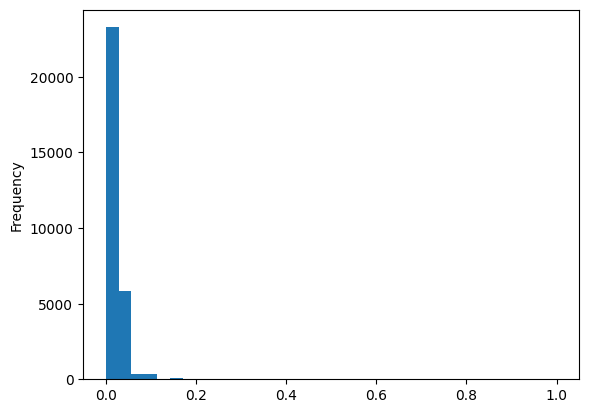

In [173]:
global_network.normalized_score.plot.hist(bins=35)

In [174]:
import numpy as np

def normalize(v):
    norm=np.linalg.norm(v)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

In [175]:
global_network[global_network['_from']=='gustavo'].sort_values('normalized_score', ascending=False).head(20)

,_from,to,score,normalized_score
13645,gustavo,petro,0.022095,0.614694
13644,gustavo,manifestar,0.002455,0.062026
13641,gustavo,evidente,0.001228,0.027483
13652,gustavo,romper,0.001228,0.027483
13649,gustavo,referir,0.001228,0.027483
13647,gustavo,pretender,0.001228,0.027483
13646,gustavo,presunto,0.001228,0.027483
13634,gustavo,aseverar,0.001228,0.027483
13640,gustavo,duda,0.001228,0.027483
13639,gustavo,detractor,0.001228,0.027483


In [294]:
from networkx.algorithms.community import greedy_modularity_communities

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in global_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Run the Louvain community detection algorithm
partition = greedy_modularity_communities(G, best_n=3)

# Create a dictionary where keys are community IDs and values are lists of nodes in that community
communities = {}
for idx, comm in enumerate(partition):
    for node in comm:
        communities[node] = idx

# Calculate the sum of scores for each node
node_scores = global_network.groupby(['_from'])['normalized_score'].sum().reset_index()

# Create a dictionary where keys are nodes and values are their corresponding scores
node_scores_dict = dict(zip(node_scores['_from'], node_scores['normalized_score']))

# Filter nodes based on the condition provided
#subgraph_filter1 = [node for node, community_id in communities.items() if community_id in [0,1,2] ]
subgraph_filter = [node for node, peso in node_scores_dict.items() if peso >=0.7]
#subgraph_nodes = list(set.intersection(set(subgraph_filter1),set(subgraph_filter2)))
subgraph = G.subgraph(subgraph_filter)

# Calculate the sum of scores for nodes in the subgraph
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Define node sizes based on the sum of scores for nodes in the subgraph
node_sizes = [(subgraph_node_scores[node]) * 800+5 for node in subgraph.nodes()]

# Create a list of node colors based on their communities
node_colors = [communities[node] for node in subgraph.nodes()]



* Plots
- With no communities
- With communities
- With Categories
- Split by categories
- Degree distribution
* Metrics
- Global
- By Category


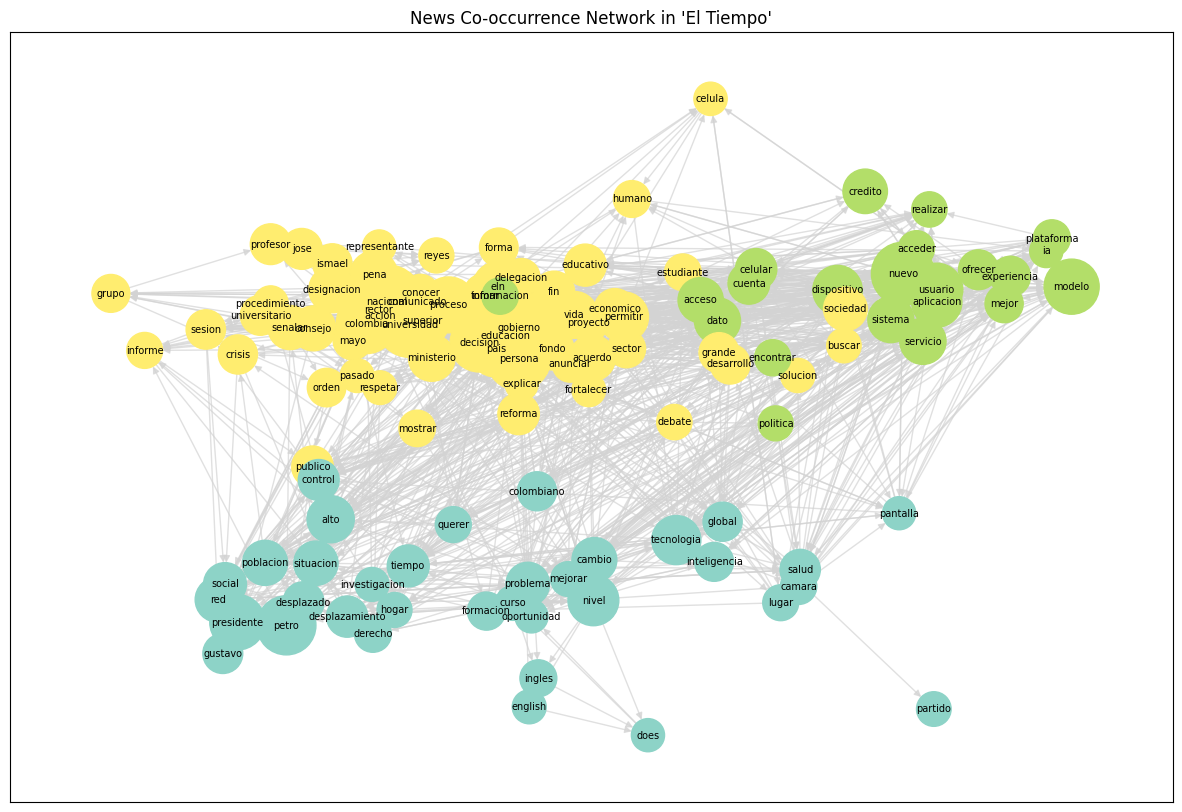

In [295]:
# Plot the subgraph with nodes sized proportionally to the sum of scores for each node
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(subgraph,k=0.2, seed=5, iterations=100)
#pos = nx.kamada_kawai_layout(subgraph,scale=0.2)

community_pos = {}
community_counts = {}
for node, community in zip(subgraph.nodes(),node_colors):
    if community in community_pos:
        community_pos[community] += np.array(pos[node])
        community_counts[community] += 1
    else:
        community_pos[community] = np.array(pos[node])
        community_counts[community] = 1

# Average the positions to find the center
for community in community_pos:
    community_pos[community] /= community_counts[community]

center = community_pos[0]+community_pos[1]#+community_pos[2]

rc =3
community_pos[0] += rc*normalize(community_pos[0]- center)
community_pos[1] += rc*normalize(community_pos[1]- center)
community_pos[2] += rc*normalize(community_pos[2]- center)

# Refine node positions to gravitate towards their community center
for node in pos:
    community = communities[node]
    pos[node] = 0.8 * np.array(pos[node]) + 0.2 * community_pos[community]
#pos = nx.spring_layout(subgraph, pos=pos,iterations=5)
#nx.draw(subgraph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set3, with_labels=True)
nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes,alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set3)
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("News Co-occurrence Network in 'El Tiempo'")

plt.show()


In [181]:
degree_centrality = nx.degree_centrality(G)

In [182]:
closeness_centrality = nx.closeness_centrality(G)

In [183]:
betweenness_centrality = nx.betweenness_centrality(G)

In [184]:
eigenvector_centrality = nx.eigenvector_centrality(G)

In [185]:
pagerank = nx.pagerank(G)

In [186]:
clustering_coefficient = nx.clustering(G)

In [187]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [188]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.004334
Closeness Centrality      0.253285
Betweenness Centrality    0.000691
Eigenvector Centrality    0.008826
PageRank                  0.000269
Clustering Coefficient    0.253955
dtype: float64

In [246]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,usuario,0.089882,usuario,0.379865,usuario,0.053220,usuario,0.186828,nacional,0.004298,autorizado,1.000000
1,aplicacion,0.076695,aplicacion,0.373953,aplicacion,0.042710,aplicacion,0.165994,gobierno,0.004247,delta,1.000000
2,dispositivo,0.071582,nuevo,0.372453,dispositivo,0.040755,dispositivo,0.157841,persona,0.003892,hepatitis,1.000000
3,nuevo,0.070775,dispositivo,0.371005,nuevo,0.039226,nuevo,0.157038,educacion,0.003824,monitorear,1.000000
4,persona,0.069699,persona,0.370365,persona,0.038411,persona,0.134530,universidad,0.003509,pronto,1.000000
5,modelo,0.067277,permitir,0.359626,modelo,0.034525,plataforma,0.119487,colombia,0.003379,socialismo,0.900000
6,tecnologia,0.062971,servicio,0.359099,tecnologia,0.032566,permitir,0.110537,usuario,0.003362,transicion,0.846154
7,dato,0.053014,red,0.356639,dato,0.024492,servicio,0.109786,nuevo,0.003344,centralizado,0.833333
8,permitir,0.052207,modelo,0.356011,permitir,0.024043,tecnologia,0.108389,dispositivo,0.003306,delantero,0.800000
9,pais,0.050054,pais,0.355900,pais,0.023323,experiencia,0.107835,pais,0.003145,apilabl,0.769231


**Degree Centrality :**

In the context of a co-occurrence network over a newspaper, degree centrality could indicate the frequency of terms or topics appearing together within articles. A low degree centrality suggests that terms or topics do not frequently co-occur, or that the newspaper covers a wide range of diverse topics without strong associations between them.

**Closeness Centrality :**

Closeness centrality could reflect how interconnected the topics covered by the newspaper are. A high closeness centrality suggests that the topics discussed in the newspaper are closely related, with articles covering a wide range of topics but still interconnected through shared themes or subjects.

**Betweenness Centrality :**

Betweenness centrality indicates the extent to which certain topics or terms act as bridges or intermediaries between other topics in the newspaper. A low betweenness centrality suggests that there are not many topics or terms that play a significant role in connecting different themes or subjects within the newspaper's content.

**Eigenvector Centrality :**

Eigenvector centrality could represent the influence or importance of certain topics or terms within the newspaper's content. A low eigenvector centrality suggests that there are not many highly influential topics or terms that consistently appear together within articles.

**PageRank:**

PageRank measures the importance of topics or terms based on their connections to other important topics or terms within the newspaper's content. A low PageRank value indicates that there are not many topics or terms that are highly recommended or frequently referenced within articles.

**Clustering Coefficient :**

In the context of a co-occurrence network over a newspaper, a high clustering coefficient suggests that there are clusters or groups of topics that are frequently discussed together within articles. This could indicate that the newspaper tends to cover certain themes or subjects in depth, with articles related to those themes often appearing together.

In [230]:
education_network = score_network_df[score_network_df['category']=='education'].groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [231]:
education_network.sort_values('score', ascending=False).head(10)

,_from,to,score
5453,universidad,nacional,0.035787
3415,ministerio,educacion,0.021873
4577,rector,universidad,0.021872
1832,educacion,superior,0.021871
3044,ismael,pena,0.019884
1541,designacion,rector,0.019221
3064,jose,ismael,0.017896
3533,nacional,colombia,0.017895
1093,consejo,superior,0.016570
3953,pena,reyes,0.015907


In [233]:
scaler = MinMaxScaler()

education_network['normalized_score'] = scaler.fit_transform(education_network[['score']])
education_network = education_network[education_network['_from'] != education_network['to'] ]

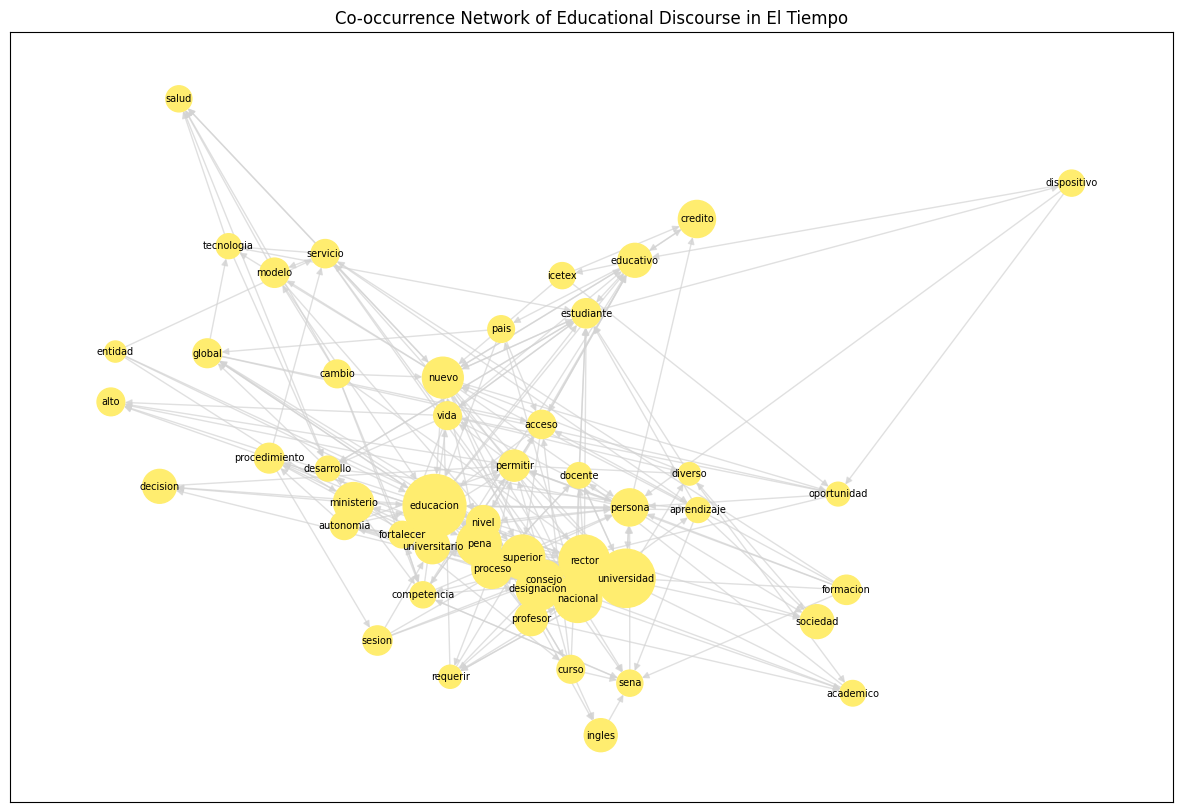

In [292]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in education_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Assuming G is your directed graph
plt.figure(figsize=(15, 10))

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Filter nodes with degree centrality >= 0.03 (at least 3)
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.03]

# Generate subgraph containing only filtered nodes
subgraph = G.subgraph(filtered_nodes)
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.2, seed=8, iterations=100)
node_sizes = [subgraph_node_scores[node] * 800 + 5 for node in subgraph.nodes()]

nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,  node_color='#FFED6F')
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("Co-occurrence Network of Educational Discourse in El Tiempo")

plt.show()


In [247]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [249]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.010010
Closeness Centrality      0.270152
Betweenness Centrality    0.001596
Eigenvector Centrality    0.015124
PageRank                  0.000493
Clustering Coefficient    0.180585
dtype: float64

In [248]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,educacion,0.127119,aplicacion,0.373953,aplicacion,0.042710,aplicacion,0.165994,nacional,0.004298,apilabl,0.769231
1,universidad,0.088512,nuevo,0.372453,dispositivo,0.040755,dispositivo,0.157841,gobierno,0.004247,bilinguismo,0.666667
2,nuevo,0.080979,dispositivo,0.371005,nuevo,0.039226,nuevo,0.157038,persona,0.003892,certificador,0.666667
3,persona,0.079096,persona,0.370365,persona,0.038411,persona,0.134530,educacion,0.003824,tercer,0.666667
4,superior,0.066855,permitir,0.359626,modelo,0.034525,plataforma,0.119487,universidad,0.003509,censo,0.535714
5,educativo,0.060264,servicio,0.359099,tecnologia,0.032566,permitir,0.110537,colombia,0.003379,inscripcion,0.535714
6,estudiante,0.059322,red,0.356639,permitir,0.024043,servicio,0.109786,nuevo,0.003344,pegunta,0.535714
7,rector,0.056497,modelo,0.356011,pais,0.023323,tecnologia,0.108389,dispositivo,0.003306,ignacio,0.500000
8,nacional,0.056497,pais,0.355900,colombia,0.022484,experiencia,0.107835,pais,0.003145,afianzamiento,0.500000
9,credito,0.054614,tecnologia,0.355863,gobierno,0.021933,celular,0.107116,social,0.003058,estudiantil,0.500000


In [264]:
tech_network = score_network_df[score_network_df['category']=='tech'].groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [265]:
tech_network.sort_values('score', ascending=False).head(10)

,_from,to,score
14467,red,social,0.014299
9129,inteligencia,artificial,0.010537
15701,sistema,operativo,0.007526
8990,inicio,sesion,0.006021
10239,map,view,0.006021
6929,experiencia,usuario,0.005770
16349,telefono,inteligente,0.005268
2651,celular,red,0.005017
12709,permitir,usuario,0.004516
12287,pagina,web,0.004516


In [266]:
scaler = MinMaxScaler()

tech_network['normalized_score'] = scaler.fit_transform(tech_network[['score']])
tech_network = tech_network[tech_network['_from'] != tech_network['to'] ]

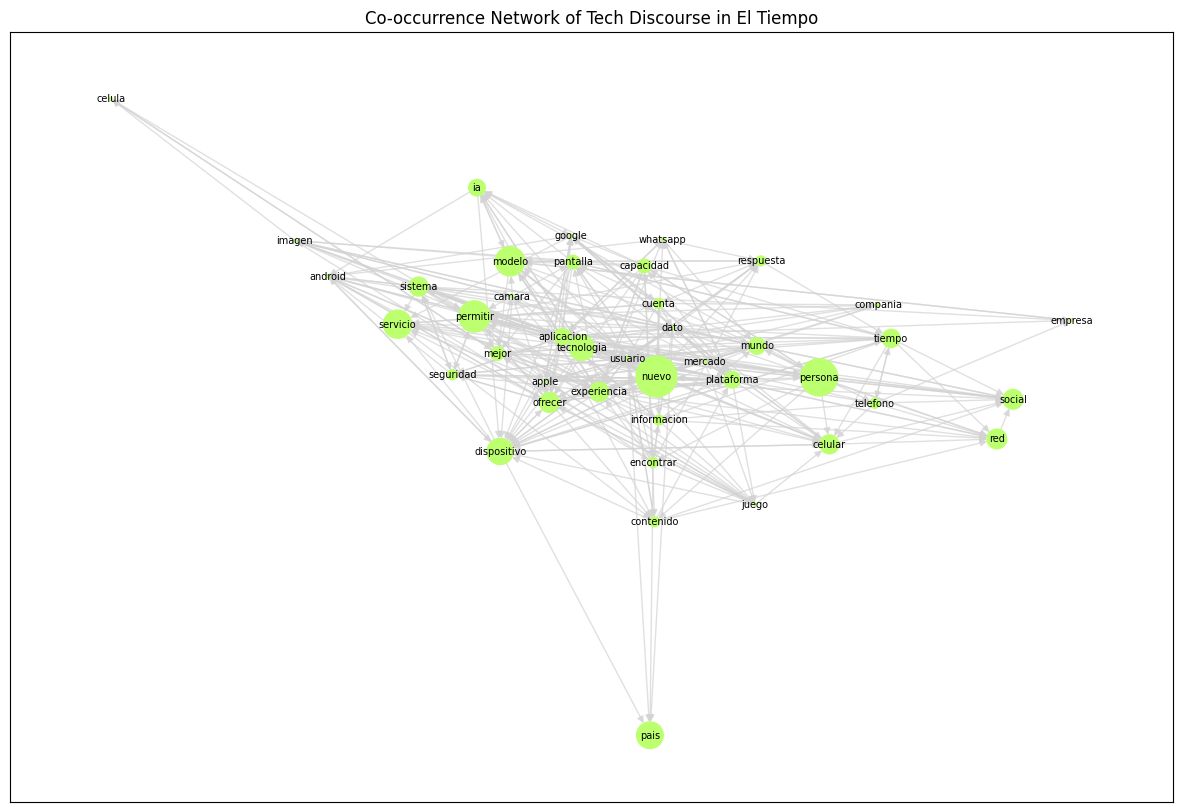

In [291]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in tech_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Assuming G is your directed graph
plt.figure(figsize=(15, 10))

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Filter nodes with degree centrality >= 0.03 (at least 3)
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.03]

# Generate subgraph containing only filtered nodes
subgraph = G.subgraph(filtered_nodes)
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.2, seed=8, iterations=100)
node_sizes = [subgraph_node_scores[node] * 800 + 5 for node in subgraph.nodes()]

nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,  node_color='#BCFF6F')
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("Co-occurrence Network of Tech Discourse in El Tiempo")
plt.show()


In [270]:
politic_network = score_network_df[score_network_df['category']=='politic'].groupby(['_from','to']).agg(score=('tfidf_score', 'sum')).reset_index()

In [271]:
politic_network.sort_values('score', ascending=False).head(10)

,_from,to,score
3009,gustavo,petro,0.022095
4952,presidente,gustavo,0.016571
1816,desplazamiento,forzado,0.016568
4963,presidente,petro,0.014730
1628,delegacion,gobierno,0.011047
3063,hogar,desplazado,0.008592
5343,red,social,0.007365
2523,fin,economico,0.007365
5582,retencion,economico,0.007365
1729,derechos,humanos,0.007365


In [273]:
scaler = MinMaxScaler()

politic_network['normalized_score'] = scaler.fit_transform(politic_network[['score']])
politic_network = politic_network[politic_network['_from'] != politic_network['to'] ]

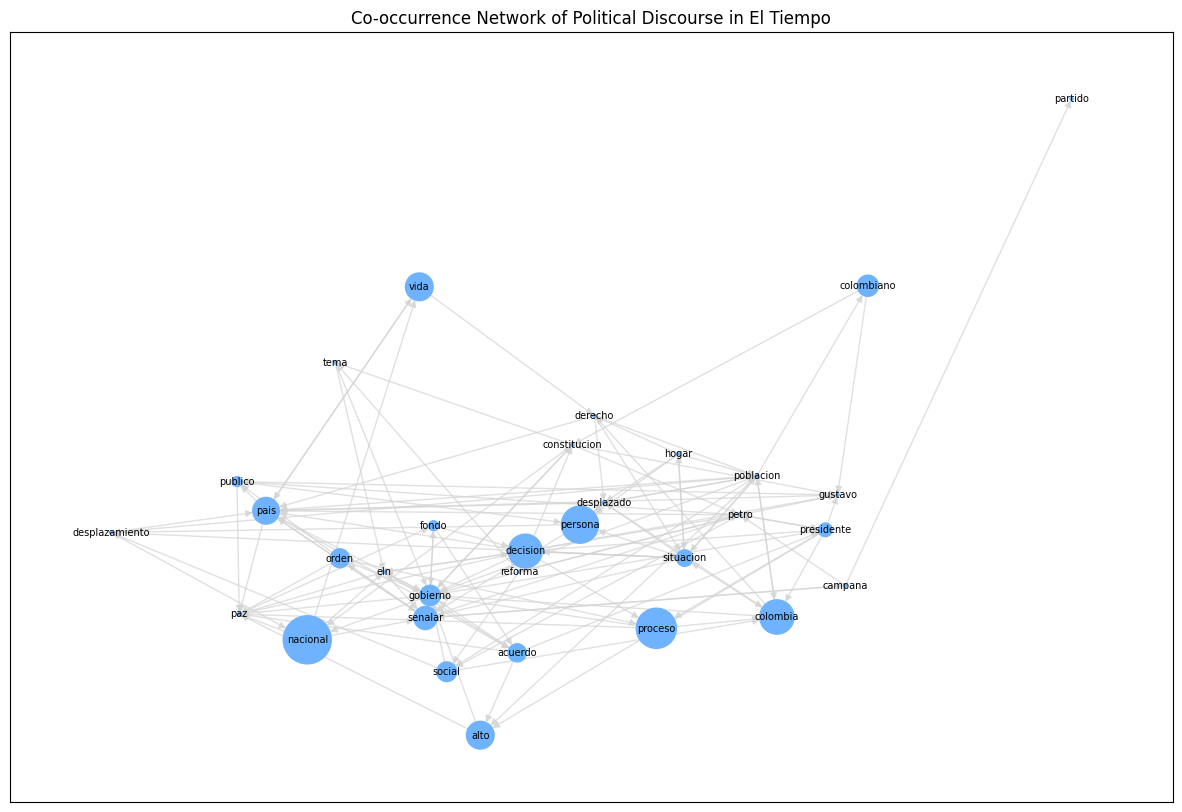

In [290]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add edges from the DataFrame with weights
for _, row in politic_network.iterrows():
    G.add_edge(row['_from'], row['to'], weight=row['normalized_score'])

# Assuming G is your directed graph
plt.figure(figsize=(15, 10))

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Filter nodes with degree centrality >= 0.03 (at least 3)
filtered_nodes = [node for node, centrality in degree_centrality.items() if centrality >= 0.03]

# Generate subgraph containing only filtered nodes
subgraph = G.subgraph(filtered_nodes)
subgraph_node_scores = {node: node_scores_dict.get(node, 0) for node in subgraph.nodes()}

# Visualize the subgraph
pos = nx.spring_layout(subgraph, k=0.3, seed=9, iterations=100)
node_sizes = [subgraph_node_scores[node] * 800 + 5 for node in subgraph.nodes()]

nx.draw_networkx_edges(subgraph, pos, node_size=node_sizes, alpha=0.7, edge_color='lightgray')
nx.draw_networkx_nodes(subgraph, pos, node_size=node_sizes,  node_color='#6FB3FF')
nx.draw_networkx_labels(subgraph, pos, font_size=7)
plt.title("Co-occurrence Network of Political Discourse in El Tiempo")
plt.show()


In [281]:
network_metrics = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
    'PageRank': [pagerank[node] for node in G.nodes()],
    'Clustering Coefficient': [clustering_coefficient[node] for node in G.nodes()]
})

In [282]:
network_metrics.mean(numeric_only=True)

Degree Centrality         0.008177
Closeness Centrality      0.263515
Betweenness Centrality    0.001282
Eigenvector Centrality    0.012168
PageRank                  0.000431
Clustering Coefficient    0.196177
dtype: float64

In [283]:
# Calculate top 5 nodes for each metric with their names and values
top_nodes_by_metric = pd.DataFrame()

for metric in network_metrics.columns[1:]:
    top_nodes_by_metric[f'Top Node for {metric}'] = [node for node in network_metrics.nlargest(10, metric)['Node']]
    top_nodes_by_metric[f'{metric} Value'] = [value for value in network_metrics.nlargest(10, metric)[metric]]

top_nodes_by_metric

,Top Node for Degree Centrality,Degree Centrality Value,Top Node for Closeness Centrality,Closeness Centrality Value,Top Node for Betweenness Centrality,Betweenness Centrality Value,Top Node for Eigenvector Centrality,Eigenvector Centrality Value,Top Node for PageRank,PageRank Value,Top Node for Clustering Coefficient,Clustering Coefficient Value
0,gobierno,0.128571,nuevo,0.372453,nuevo,0.039226,nuevo,0.157038,nacional,0.004298,socialismo,0.900000
1,petro,0.092857,persona,0.370365,persona,0.038411,persona,0.134530,gobierno,0.004247,lleras,0.666667
2,nacional,0.069841,permitir,0.359626,dato,0.024492,permitir,0.110537,persona,0.003892,pumarejo,0.666667
3,presidente,0.066667,servicio,0.359099,permitir,0.024043,servicio,0.109786,educacion,0.003824,breve,0.666667
4,colombia,0.063492,red,0.356639,pais,0.023323,experiencia,0.107835,colombia,0.003379,optimo,0.666667
5,pais,0.061905,pais,0.355900,colombia,0.022484,dato,0.105978,nuevo,0.003344,guerra,0.666667
6,reforma,0.054762,educacion,0.354981,gobierno,0.021933,red,0.104036,pais,0.003145,detractor,0.666667
7,poblacion,0.053175,experiencia,0.353520,educacion,0.019046,pais,0.098082,social,0.003058,escandaloso,0.611111
8,decision,0.053175,dato,0.352179,servicio,0.018938,ofrecer,0.095802,decision,0.002781,lar,0.607143
9,eln,0.052381,tiempo,0.351314,sistema,0.018837,sistema,0.095458,petro,0.002676,documentado,0.583333


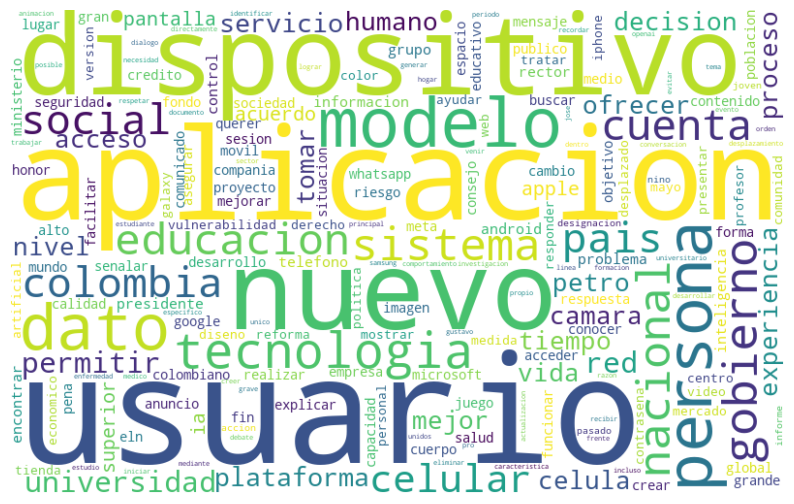

In [192]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

# Example raw text
raw_text = ' '.join(documents_clean)

# Function to preprocess and compute word frequencies
def calculate_frequencies(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Tokenize the text into words
    words = text.split()
    # Calculate frequencies
    frequencies = Counter(words)
    return frequencies

# Calculate frequencies
word_frequencies = calculate_frequencies(raw_text)

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_frequencies)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()


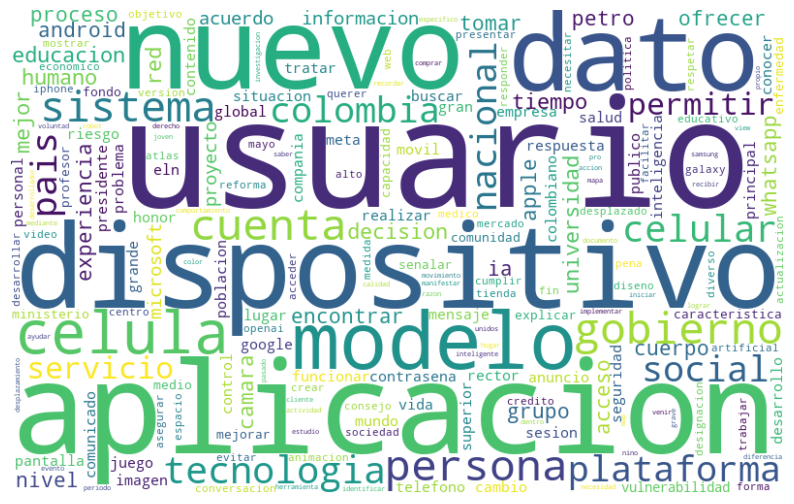

In [293]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(documents_clean)

# Get feature names and tf-idf array
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

# Calculate total tf-idf score for each word
word_tfidf_scores = np.sum(tfidf_scores, axis=0)
word_tfidf_dict = dict(zip(feature_names, word_tfidf_scores))

# Generate word cloud
wc = WordCloud(width=800, height=500, background_color='white').generate_from_frequencies(word_tfidf_dict)

# Display the word cloud
plt.figure(figsize=(10, 7))  # Size of the plot
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()